In [1]:
from torch import nn
import numpy as np
import pandas as pd
import pickle
import os
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torch
import random

In [2]:
with open(os.path.join("..","tensor_final"),"rb") as f:
    data_lc = pickle.load(f)
data_lc.shape

torch.Size([3000, 40])

In [5]:
class Autoencoder(nn.Module):
    
    def __init__(self):        
        super(type(self), self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(40,100),
            nn.ReLU(),
            nn.Linear(100,150),
            nn.ReLU(),
            nn.Linear(150,50),
            nn.ReLU(),
            nn.Linear(50,30),
            nn.ReLU(),
            nn.Linear(30,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,30),
            nn.ReLU(),
            nn.Linear(30,50),
            nn.ReLU(),
            nn.Linear(50,150),
            nn.ReLU(),
            nn.Linear(150,100),
            nn.ReLU(),
            nn.Linear(100,40)
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [16]:
from torch.utils.data.dataset import random_split
from tqdm.notebook import tqdm
model = Autoencoder()
train_dataset,valid_dataset = random_split(data_lc,[2000,1000])
loader_train = DataLoader(train_dataset.dataset.float().reshape(-1,40), batch_size=64, shuffle=True)
loader_valid = DataLoader(valid_dataset.dataset.float().reshape(-1,40), batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
epocas = 1000
loss_g = np.zeros((epocas,2))
best_valid_loss = 1e4
for epoch in tqdm(range(epocas)):
    loss_epoch_train = 0.0
    loss_epoch_valid = 0.0
    for data in loader_train:#entrenamiento
        optimizer.zero_grad()
        prediction = model(data)
        loss = criterion(prediction, data)
        loss.backward()
        optimizer.step()
        loss_epoch_train += loss.item()
    loss_g[epoch,0] = loss_epoch_train/len(loader_train.dataset)
    for data in loader_valid:
        prediction = model(data)
        loss = criterion(prediction,data)
        loss_epoch_valid += loss.item()
    loss_g[epoch,1] = loss_epoch_valid/len(loader_valid.dataset)
    if loss < best_valid_loss:
        best_valid_loss = loss
        torch.save({'epoca': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss}, 
                       'best_model.pt')


  0%|          | 0/1000 [00:00<?, ?it/s]

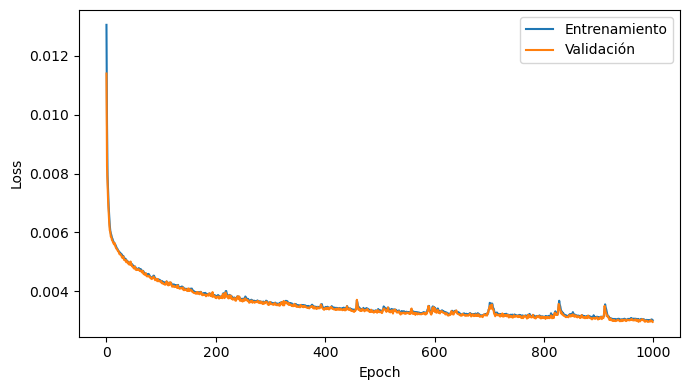

In [17]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(loss_g[:, 0], label='Entrenamiento')
ax.plot(loss_g[:, 1], label='Validación')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

esto es para comparar original contra prediccion del autoencoder

In [18]:
saved_model = torch.load('best_model.pt')
model.state_dict(saved_model["model_state_dict"])
saved_model["epoca"]

948

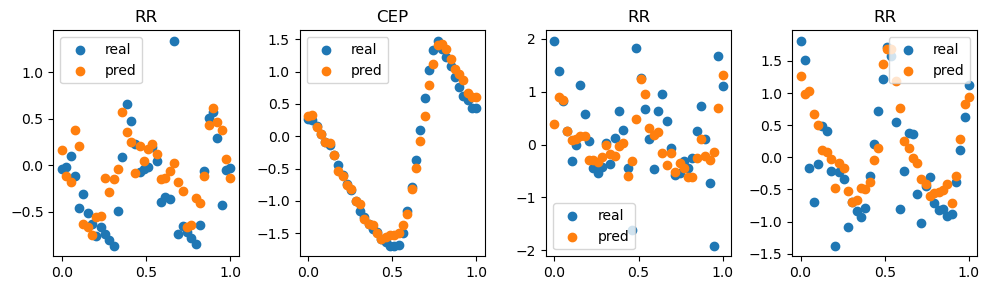

In [22]:
x = data_lc.float().reshape(-1, 40)
z = model(x).detach().numpy()
ax_x = np.linspace(0,1,40)
data_random = random.sample(range(0,3000),4)
fig,ax = plt.subplots(1,4,figsize=(10,3),tight_layout=True)
aux_type = {0:"CEP",1:"ECL",2:"RR"}
for idx_r,ax_ in zip(data_random,ax):
    ax_.scatter(ax_x,data_lc[idx_r],label="real")
    ax_.scatter(ax_x,z[idx_r],label="pred")
    ax_.legend()
    ax_.set_title(aux_type[(idx_r//1000)%3])